# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [4]:
def P1(num_examples=5):
    "Returns first five training samples and their lables"
    first_five_text = train_data[:num_examples] #limits to first 5 examples of text
    first_five_labels = train_labels[:num_examples]#limits to first 5 examples of labels
    labels_str = np.where(first_five_labels == 0, 'alt.atheism', #converts integers to label
         (np.where(first_five_labels ==1, 'comp.graphics', (np.where(first_five_labels ==2, 'sci.space', 'talk.religion.misc'))))) 
    
    for idx,i in enumerate(first_five_text): #iterates over first five examples in train data 
        for ix, j in enumerate(labels_str):
            if idx == ix:
                print(f'{j}: {i}')
                
    

            


P1(5)

comp.graphics: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
talk.religion.misc: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
sci.space: 
 >In article <

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [5]:
def non_zero(data):
    "Returns average of non-zero entries"
    non_zero_row = np.count_nonzero(data, axis =1)
    mean = np.mean(non_zero_row)
    return mean

def unigram(data):
    "Creates Unigram and returns size of vocab, non-zero entries, fraction of non-zero entries, and first and last string"
    count_vec = CountVectorizer(ngram_range=(1, 1))
    X = count_vec.fit_transform(data)
    X = X.toarray() #converts it to array type
    names = count_vec.get_feature_names()
    names = sorted(names)
    print(f'The size of the vocabulary in the unigram is : {len(names)}')
    
    #Average non-zero entries
    print(f'The average non-zero entries per row in the unigram is {non_zero(X)}')
    
    #fraction of non-zero to entries in array
    non_zero_total = np.count_nonzero(X) #counts non-zero entries in sparse array
    print(f'The fraction of the non-zero entries in the unigram matrix is {non_zero_total/54671886}') 
    
    #The frist and last string
    print(f'The first string in the unigram is {names[0]}')
    print(f'The last string in the unigram is {names[-1]}')
    
unigram(train_data)   

def spec_unigram(data, vals =  ["atheism", "graphics", "space", "religion"]):
    "Creates unigram using specific vocab"
    count_vec = CountVectorizer(ngram_range=(1,1), vocabulary=vals)
    X = count_vec.fit_transform(data)
    X = X.toarray()
    names = count_vec.get_feature_names() #gets the words in the vocab
    #returns length of vocaubulary
    print(f'The length of the vocabulary we specified is {len(names)}')
    
    #get the average of nunber of nonzero entries
    print(f'the average non-zero entries for the unigram with a specified vocab per example is {non_zero(X)}')
    
    
spec_unigram(train_data)  

def char_bigram(data):
    "Creates Matrix of Bigram-Trigram features based on characters"
    count_vec = CountVectorizer(analyzer='char', ngram_range=(2,3))
    X = count_vec.fit_transform(data)
    X = X.toarray()
    vocab = count_vec.get_feature_names()
    print(f'The size of the vocabulary for the bigram is {(len(vocab))}')
    
char_bigram(train_data)

def big_unigram(data):
    "Returns unigram for words that appear in at least 10 docs"
    count_vec = CountVectorizer(ngram_range=(1,1), min_df=10) #only accounts for words that appear in at least 10 docs
    X = count_vec.fit_transform(data)
    X = X.toarray()
    vocabulary = count_vec.get_feature_names()
    print(f'The size of the vocabulary with a frequency of 10 is {len(vocabulary)}')

big_unigram(train_data)

def simple_unigram(data):
    "Returns unigram for train and development data. Compares the length of the vocabulary in each"
    count_vec = CountVectorizer(ngram_range=(1, 1))
    X = count_vec.fit_transform(data)
    X = X.toarray()
    vocab = count_vec.get_feature_names()
    return vocab

def prop_dif(train_data, dev_data): #ask
    "Returns the size difference between the vocabularies"
    cv_dev = CountVectorizer() #cv for dev features
    dev_dta_uni = cv_dev.fit_transform(dev_data)
    dev_features = cv_dev.get_feature_names() #dev features
    cv_train = CountVectorizer()
    cv_train.fit_transform(train_data)
    train_features = cv_train.get_feature_names()
    vocab_dif = []
    for lab in dev_features:
        if lab not in train_features:
            vocab_dif.append(lab)
    return str(len(vocab_dif)/dev_dta_uni.shape[1])
            
    #dif = len(simple_unigram(train_data))- len(simple_unigram(dev_data))
    #dif = np.setdiff1d(simple_unigram(dev_data), simple_unigram(train_data)) 
    #return len(dif)
print(f"The fraction of the words in the development category missing in the training category is: {prop_dif(train_data, dev_data)}")


The size of the vocabulary in the unigram is : 26879
The average non-zero entries per row in the unigram is 96.70599803343165
The fraction of the non-zero entries in the unigram matrix is 0.0035978272269590263
The first string in the unigram is 00
The last string in the unigram is zyxel
The length of the vocabulary we specified is 4
the average non-zero entries for the unigram with a specified vocab per example is 0.26843657817109146
The size of the vocabulary for the bigram is 35478
The size of the vocabulary with a frequency of 10 is 3064
The fraction of the words in the development category missing in the training category is: 0.24787640034470024


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [6]:
#transforms data into unigram
def simple_unigram(train_data, dev_data):
    "Returns unigram for train and development data. Compares the length of the vocabulary in each"
    count_vec = CountVectorizer(ngram_range=(1, 1))
    X_train = count_vec.fit_transform(train_data)
    X_dev = count_vec.transform(dev_data)
    #X = X.toarray()
    return X_train, X_dev
train_uni, dev_uni = simple_unigram(train_data, dev_data)
train_uni.shape, dev_uni.shape


((2034, 26879), (676, 26879))

In [7]:
def knn(train_x, train_y, dev_x, dev_y):
    "Returns KNN model with varying k, including one that minimizes f1 score"
    lists = []
    for idx, i in enumerate(range(1, 30, 2)):
        knn = KNeighborsClassifier(n_neighbors=i) #innitializes knn object
        knn.fit(train_x, train_y) #fits knn
        y_hat = knn.predict(dev_x) 
        f_1 = metrics.f1_score(dev_y, y_hat, average = "weighted")
        print(f'k:{i}, f1:{f_1}')
        lists.append((i, f_1))
    print(f'The K with the max F1:{max(lists, key=lambda x: x[1])}')
    
        
knn(train_uni, train_labels, dev_uni, dev_labels)

k:1, f1:0.3805030018531525
k:3, f1:0.4084150225437623
k:5, f1:0.4287607236218357
k:7, f1:0.45047910006117586
k:9, f1:0.4365666176198027
k:11, f1:0.4266108018696209
k:13, f1:0.42404338833763805
k:15, f1:0.4326339805547054
k:17, f1:0.4485853212909305
k:19, f1:0.4365794782510113
k:21, f1:0.42609394906353587
k:23, f1:0.40811738399495695
k:25, f1:0.41610581482270387
k:27, f1:0.424466893547113
k:29, f1:0.4337845889784843
The K with the max F1:(7, 0.45047910006117586)


In [8]:
def mnb(train_data, train_labels, dev_data, dev_labels):
    "Trains and returns a multinomial naive bayes model"
    lists = []
    for i in np.arange(0, 6, 0.04):
        nb = MultinomialNB(alpha=i) #innitiales multinomial naive bayes object
        nb.fit(train_data, train_labels) #fits model
        y_hat = nb.predict(dev_data) #predicts on dev data
        f1= metrics.f1_score(dev_labels, y_hat, average='weighted')
        print(f"alpha:{i}, f1:{f1}")
        lists.append((i, f1))
    print(f'The alpha with the max F1:{max(lists, key=lambda x: x[1])}')
    
mnb(train_uni, train_labels, dev_uni, dev_labels)

alpha:0.0, f1:0.747240657284563
alpha:0.04, f1:0.7844433334970073


/Users/daniellampert/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


alpha:0.08, f1:0.7882562245205091
alpha:0.12, f1:0.7885466350292981
alpha:0.16, f1:0.7890126577144015
alpha:0.2, f1:0.7876298330892171
alpha:0.24, f1:0.7890335791591067
alpha:0.28, f1:0.7918868148009902
alpha:0.32, f1:0.787644978407044
alpha:0.36, f1:0.7892825222409318
alpha:0.4, f1:0.7878811683059115
alpha:0.44, f1:0.7876928204244801
alpha:0.48, f1:0.7876928204244801
alpha:0.52, f1:0.7863020350100258
alpha:0.56, f1:0.7846696399117374
alpha:0.6, f1:0.7860752087513914
alpha:0.64, f1:0.7860752087513914
alpha:0.68, f1:0.7847459594060138
alpha:0.72, f1:0.7847459594060138
alpha:0.76, f1:0.7845011169448908
alpha:0.8, f1:0.7845011169448908
alpha:0.84, f1:0.7810859843567709
alpha:0.88, f1:0.7810859843567709
alpha:0.92, f1:0.7794132111647282
alpha:0.96, f1:0.7777320236017224
alpha:1.0, f1:0.7777320236017224
alpha:1.04, f1:0.7777320236017224
alpha:1.08, f1:0.7729664127305673
alpha:1.12, f1:0.7729664127305673
alpha:1.16, f1:0.7712636674021938
alpha:1.2, f1:0.7726362310322734
alpha:1.24, f1:0.7712

In [9]:
def multi_log(train_data, train_labels, dev_data, dev_labels):
    "Trains and returns multi-class logistic regression model"
    lists = []
    for c in np.arange(1, 14,.5):
        log_mod = LogisticRegression(C = c, solver="liblinear", multi_class="auto")
        log_mod.fit(train_data, train_labels)
        y_hat = log_mod.predict(dev_data)
        f_1 = metrics.f1_score(dev_labels, y_hat, average='weighted')
        coef = log_mod.coef_
        squared_weights = np.sum(np.square(coef))
        print(f'c:{c} f1:{f_1}, squared weights:{squared_weights}')
        lists.append((c, f_1)) #append values into tuple 
    print(f'The C with the max F1:{max(lists, key=lambda x: x[1])}')
multi_log(train_uni, train_labels, dev_uni, dev_labels)  

c:1.0 f1:0.6944172871853819, squared weights:601.6147641014375
c:1.5 f1:0.6889998700970759, squared weights:776.7240378476646
c:2.0 f1:0.6924826561168351, squared weights:921.8360969365771
c:2.5 f1:0.6910442144257875, squared weights:1047.369034122505
c:3.0 f1:0.6910442144257875, squared weights:1158.534543680072
c:3.5 f1:0.6894367162292433, squared weights:1258.5955675789246
c:4.0 f1:0.6894367162292433, squared weights:1350.1086491627113
c:4.5 f1:0.6894367162292433, squared weights:1434.3740489176528
c:5.0 f1:0.6910114442307702, squared weights:1512.9424177191984
c:5.5 f1:0.6926384514126078, squared weights:1587.3288839934035
c:6.0 f1:0.6910150917913751, squared weights:1656.2835033608633
c:6.5 f1:0.6926477465740102, squared weights:1720.8321549566583
c:7.0 f1:0.6911048942184228, squared weights:1784.2051804359437
c:7.5 f1:0.6895006056491882, squared weights:1843.622898675653
c:8.0 f1:0.6877753618061956, squared weights:1900.5525054404636
c:8.5 f1:0.6877753618061956, squared weights:1

ANSWER:
4. KNN does not work well for this problem because the data is relatively high dimensional. Establishing decision bounderies in high dimensional data does not typically work super well. This is the case because establishing bounderies becomes very complicated. Moreover, KNN is a computationally intensive algorithm in the case of sparse matrices. For this situation, it is not the most appropriate choice. 

5. In this case, Naive Bayes was more accurate than logistic regression. I believe this is the case because the training data size is relatively small in comparison to the number of features. In this case, the generative nature of Naive Bayes is beneficial and increases the speed of convergence. With a larger training set, Logistic Regression would likely start to outperform Naive Bayes.

6. As C increases in the logistic regression the weights continually increase. 

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

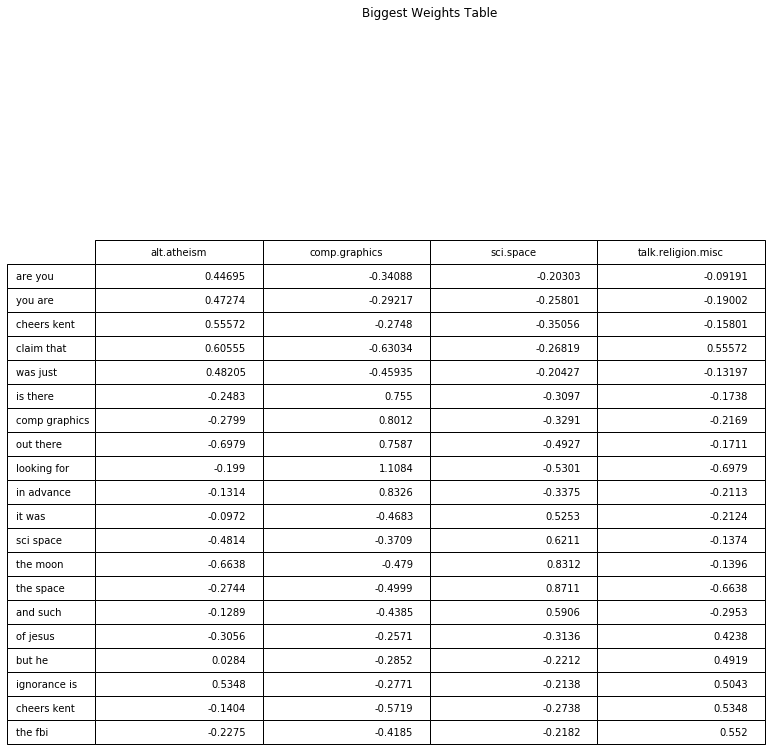

In [10]:
def bigram(train_data, dev_data):
    "Returns bigram for train and development data. Compares the length of the vocabulary in each"
    count_vec = CountVectorizer(ngram_range=(2, 2))
    X_train = count_vec.fit_transform(train_data)
    X_dev = count_vec.transform(dev_data)
    #X = X.toarray()
    return count_vec.get_feature_names() , X_train, X_dev
train_vocab, train_bigram, dev_bigram = bigram(train_data, dev_data)

def logit_weights(train_data, train_vocab, train_labels):
    "Fits logistic regression model and tests on dev data"
    log_mod = LogisticRegression(C=0.5, solver = "liblinear", multi_class="auto") #innitializes logistic regression object
    log_mod.fit(train_data, train_labels) #fits logistic regression model
    coefs = log_mod.coef_
    weight_indices = np.argpartition(coefs, -5)[:, -5:]
    feat = []
    for i in weight_indices: 
        for x in i:
            feat.append(train_vocab[x])
    feat_1 = np.round(np.take(log_mod.coef_[0], weight_indices), 5)
    feat_2= np.round(np.take(log_mod.coef_[1], weight_indices), 4)
    feat_3 = np.round(np.take(log_mod.coef_[2], weight_indices), 4)
    feat_4 = np.round(np.take(log_mod.coef_[3], weight_indices), 4)
    
    col_vals = np.transpose(np.column_stack((feat_1, feat_2, feat_3, feat_4)))
    col_labels = ["alt.atheism", "comp.graphics", "sci.space", "talk.religion.misc"]
    
    tab = plt.table(cellText=col_vals, colLabels = col_labels, rowLabels=feat)
    tab.scale(2,2)
    plt.title("Biggest Weights Table")
    plt.grid(False)
    plt.axis('off')
    plt.show()

    
logit_weights(train_bigram, train_vocab, train_labels)
    
    
    
    
    

ANSWER: I'm surprised by the presence of negative values. I interpret this as some bigrams have no association with a certain topic. I'm also surprised that "are you" and "you are" are strongly associated with "alt.atheism". It does not seem like they would be highly related

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [10]:
#required downloads to use nltk
nltk.download('stopwords') #download list of stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniellampert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/daniellampert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/daniellampert/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/daniellampert/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/daniellampert/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [81]:
def better_preprocessor(s):
    "Makes strings more consistent for better prediction"
    s = s.lower() #converts string to lowercase
    s = re.sub(r'\d+', ' num ', s) #converts numbers to string "num"
    s = re.sub("[^A-Za-z0-9 \\n]", " ", s) #removes non-letter, non-number characters
    
    s = s.strip() #removes white space
    s = " ".join(s.split()) 
    s = s.replace('[^\w\s]','')
    #stop_words are technically not preprocessing
    
    stop_words = ['the', 'me', 'my', 'we', 'a', 'he', 'she',\
                  'they', 'it', 'its', 'i', 'you', 'yours', 'am', 'them', 'being', 'too', 'to', 'our', 'ours',\
                 'is', 'are', 'was', 'had', 'has', 'did', 'and']
    for i in stop_words: #iterates over stop words
        s = s.replace(i, "")
    ps = nltk.stem.SnowballStemmer("english") #.PorterStemmer()
    for w in s: 
        s = s.replace(w, ps.stem(w))
    #s = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(s)))
    s = re.sub('\s(\d*\s\w*\s\d*)\s', ' date ', s) # replace dates with string 'date'
    return s
def empty_pre_proc(s):
    "empyter preprocessor"
    return s

def P5():
    "Creates two logistic regression models. One where the data is pre-processed, one that is not"
    def logistic_regression(train_data, train_labels, dev_data, dev_labels):
        "Trains a logistic regression algorithm"
        logit = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
        logit.fit(train_data, train_labels) # fits model
        y_hat = logit.predict(dev_data)  # predict onto dev data
        print(f"The F1 score is : {metrics.f1_score(dev_labels, y_hat, average = 'weighted')}")

              
    def processed_count_vec(train_data, dev_data, processor): #give empty processor
        "Returns count vec that uses preprocessing"
        cv = CountVectorizer(preprocessor=processor)
        X_train = cv.fit_transform(train_data)
        X_dev = cv.transform(dev_data)
        vocabulary = cv.get_feature_names()
        print(f'The size of the vocabulary is : {len(vocabulary)}')
        return X_train, X_dev
    # Process Data
    stand_train_data, stand_dev_data = processed_count_vec(train_data, dev_data, processor=empty_pre_proc) #Processed data without pre-process
    #Process data with preprocessing
    pre_train_data, pre_dev_data = processed_count_vec(train_data, dev_data, processor=better_preprocessor)
    #fit both models
    logistic_regression(stand_train_data, train_labels, stand_dev_data, dev_labels) #the F1 score for the non-preprocessed data
    logistic_regression(pre_train_data, train_labels, pre_dev_data, dev_labels) # the F1 score for the pre-processed data
              
        
    
    ### STUDENT START ###
    ### STUDENT END ###

P5()  


The size of the vocabulary is : 33291
The size of the vocabulary is : 21260
The F1 score is : 0.7069109185493502
The F1 score is : 0.7240262061663476


The improved model decreased vocabulary size by slightly more than 12k words, or approximately 36%.

### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

The L1 regularization strength is 0.1, the size of the vocab is 218.0 the F1 Score is 0.7
The L1 regularization strength is 0.3, the size of the vocab is 532.0 the F1 Score is 0.68
The L1 regularization strength is 0.5, the size of the vocab is 732.0 the F1 Score is 0.67
The L1 regularization strength is 0.7, the size of the vocab is 928.0 the F1 Score is 0.68


/Users/daniellampert/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The L1 regularization strength is 0.9, the size of the vocab is 1031.0 the F1 Score is 0.68
The L1 regularization strength is 1.1, the size of the vocab is 1205.0 the F1 Score is 0.69
The L1 regularization strength is 1.3, the size of the vocab is 1295.0 the F1 Score is 0.69
The L1 regularization strength is 1.5, the size of the vocab is 1384.0 the F1 Score is 0.68
The L1 regularization strength is 1.7, the size of the vocab is 1481.0 the F1 Score is 0.68
The L1 regularization strength is 1.9, the size of the vocab is 1564.0 the F1 Score is 0.67
The L1 regularization strength is 2.1, the size of the vocab is 1555.0 the F1 Score is 0.69
The L1 regularization strength is 2.3, the size of the vocab is 1758.0 the F1 Score is 0.69
The L1 regularization strength is 2.5, the size of the vocab is 1649.0 the F1 Score is 0.69
The L1 regularization strength is 2.7, the size of the vocab is 1813.0 the F1 Score is 0.69
The L1 regularization strength is 2.9, the size of the vocab is 1776.0 the F1 Sc

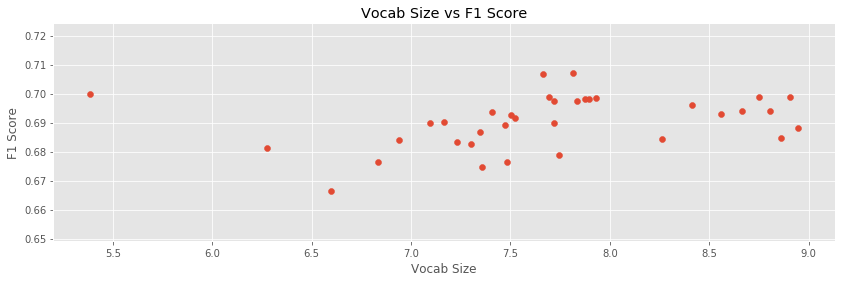

In [82]:
    
def P6():
    #Keep this random seed here to make comparison easier.
    np.random.seed(0)
    c_small, c_big = np.arange(0.1, 5, 0.2), np.arange(6, 100, 10)
    c =  np.concatenate([c_small, c_big])# sets range of c values for penalization
    f1 = np.zeros(len(c))
    vocab_size = np.zeros(len(c))
    non_zero_weights = np.zeros(len(c))
    
    def logit(train_x, train_y, dev_x, dev_y, penal, c, tol = 0.015):
        "Helper function for logistic regression"
        log_reg = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty=penal, tol=tol)
        log_reg.fit(train_x, train_y)
        return log_reg
    
    #iterate over length of penalization to set up logit model
    for i in range(len(c)):
        cv = CountVectorizer()
        train_transform = cv.fit_transform(train_data) #transforms the training data into count vectorizer
        dev_transform = cv.transform(dev_data)
        #train logistic regression model with l1 penalty
        log_l1 = logit(train_uni, train_labels, dev_transform, dev_labels, penal="l1", c = c[i]) #train model, object is trained log_reg
        vocab_size[i] = np.count_nonzero(np.apply_along_axis(np.count_nonzero, 0, log_l1.coef_)) #counts non-zero entries
        non_zero_weights[i] = np.sum(np.apply_along_axis(np.count_nonzero, 0, log_l1.coef_))
        #find coefficients that are not zero
        mask = log_l1.coef_!=0
        idx = mask.any(axis = 0)
        train_non_0, dev_non_0 = train_transform[:, idx], dev_transform[:, idx] 
        
        #Train and predict with l2 penalization
        log_l2 = logit(train_non_0, train_labels, dev_non_0, dev_labels, penal = "l2", c = 0.5)
        y_hat = log_l2.predict(dev_non_0) #predict on dev data without 0 entries
        f1[i] = metrics.f1_score(y_true=dev_labels, y_pred=y_hat, average='weighted')
        print(f'The L1 regularization strength is {round(c[i], 2)}, the size of the vocab is {round(vocab_size[i],1)} the F1 Score is {round(f1[i],2)}')
    #create plot
    plt.style.use('ggplot')
    plt.figure(figsize=(14, 4))
    plt.scatter(np.log(vocab_size), f1)
    plt.xlabel("Vocab Size")
    plt.ylabel("F1 Score")
    plt.title("Vocab Size vs F1 Score")
    
    ### STUDENT START ###
    ### STUDENT END ###

P6()

ANSWER: There is a non-linear relationship between vocabulary size and f1 score. Besides the one outlier with a high f1 score and a low vocabulary size, the f1 score with a small vocabulary is fairly low and continually grows as the vocabulary grows larger, peaking at around 2500 then the f1 score goes down again. I am surprised that the relationship is as flat as it is.

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [83]:
def P7():
    def tf_idf(train_data, train_labels):
        "Term Frequency Inverse Document Frequency for text data"
        tfid = TfidfVectorizer()
        X_train = tfid.fit_transform(train_data) # TFIDF on train data
        X_dev = tfid.transform(dev_data)
        return X_train, X_dev
    def logit(train_data, train_labels, dev_data, dev_labels):
        "Fits a logistic regression model and returns the f1 score as the metric"
        lg = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
        lg.fit(train_data, train_labels)
        y_hat = lg.predict(dev_data)
        f1 = metrics.f1_score(dev_labels, y_hat, average="weighted")
        proba = lg.predict_proba(dev_data) #predicted probablility
        return y_hat,proba, f1
    tran_train, tran_dev = tf_idf(train_data, train_labels)
    y_hat, probs, f1 = logit(tran_train, train_labels, tran_dev, dev_labels)
    print(f"The F1 Score is : {f1}")
    #max_probs = np.max(probs, axis = 1)
    r_rat = []
    for i in range(len(dev_labels)):
        max_probs = np.max(probs[i])
        correct_probs = probs[i][dev_labels[i]]
        r = max_probs/correct_probs
        r_rat.append(r) 
    print(f"Top 3 r-ratios: {sorted(r_rat, reverse = True)[0:3]}") #gets largest r ratios
    indexes = [r_rat.index(929.3582382222635),r_rat.index(325.0041389124428), r_rat.index(287.30591498634175)] 
    print(indexes)
    for j in indexes:
        print(f'message:{j}')
        print(f'Label:{dev_labels[j]}')
        print(f'Predicted Label: {y_hat[j]}')
        
        print("The associated text is\
        [")
        print(dev_data[j])
        print("\
        ]")
    

P7()

The F1 Score is : 0.7597662427853104
Top 3 r-ratios: [929.3582382222635, 325.0041389124428, 287.30591498634175]
[215, 665, 607]
message:215
Label:3
Predicted Label: 1
The associated text is        [
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges)

ANSWER: 
1. Count Vectorizer simply counts the frequency of words. TFID Vectorizer increases the value proportionally to the count, but is inversely proportional to the word in the total body of text. This means that TFID accounts for the fact that some words are more commonly used, and thus, most likely less usefull in prediction. For example, the word "the" probably has a very high count throughout the corpus but likely is useless in prediction since it is not unique to certain categories. 
2. In this exercise, the performance increased with TFID as seen in the higher F1 score. 

3. The R ratio describes the ratio of the maximum predicted probality to the probability of the correct label. It shows how far the predicted probabilities are from the actual probabilities. This means that a higher R score is worse. 
4. One potential mistake the model is making is that certain key words that are generally associated with a given topic are leading to the incorrect classification of other bodies of text. I think this is the case because two of the 3 topics are very short in length. Therefore an individual word could potentially lead to its misclassification. Although topic 1 is much longer in length, I think the classification issue is the same because it contains text associated with computer graphics but the topic is actually religion. My suggestion would be to adjust the weights of keep words to improve external validity. 

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.

In an attempt to deal with misclassification due to words that are highly associated with a certain topic, I will make the training weights even in the logistic regression model. 

In [84]:
print(np.unique(train_labels, return_counts=True)) #the distribution of classes is somewhat skewed
def tf_idf(train_data, train_labels):
        "Term Frequency Inverse Document Frequency for text data"
        tfid = TfidfVectorizer()
        X_train = tfid.fit_transform(train_data) # TFIDF on train data
        X_dev = tfid.transform(dev_data)
        return X_train, X_dev
tran_train, tran_dev = tf_idf(train_data, train_labels) #use tfidk to transform data
def balanced_logit(train_data, train_labels, dev_data, dev_labels):
    "Creates balanced logistic regression model"
    lr = LogisticRegression(C=100, solver="liblinear", multi_class="auto", class_weight='balanced')
    lr.fit(train_data, train_labels)
    y_hat = lr.predict(dev_data)
    return metrics.f1_score(dev_labels, y_hat, average = "weighted")
print(f"The F1 score for the balanced data is {balanced_logit(tran_train, train_labels, tran_dev, dev_labels)}")

(array([0, 1, 2, 3]), array([480, 584, 593, 377]))
The F1 score for the balanced data is 0.7716424381858508


That improved the F1 score by 2%!